In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, Subset

from train import * 
from src.autoencoder import * 
from Data.pendulum_dataset import *
from src.gan import *
from src.NN.multi_step_pred import *
from src.LaLiGAN.custom_emlp_laligan import *
from src.NN.custom_emlp_multistep import *

import warnings
warnings.filterwarnings("ignore", message="torch.utils._pytree._register_pytree_node is deprecated")

/mnt/d_disk/ch20b065/.conda/envs/liegan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/d_disk/ch20b065/.conda/envs/liegan/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
input_timesteps = 4
output_timesteps = 2
n_dim = 2

train_dataset = PendulumDataset(
    save_path='./data/pendulum_dataset.pkl',
    input_timesteps = input_timesteps,
    output_timesteps = output_timesteps,
    mode='train'
)

test_dataset = PendulumDataset(
    save_path='./data/pendulum_dataset.pkl',
    input_timesteps = input_timesteps,
    output_timesteps = output_timesteps,
    mode='test'
)



# Get the actual size of the dataset
train_size = 2000
test_size = 400

# Sample accordingly
train_indices = np.random.choice(len(train_dataset), size=train_size, replace=False)
test_indices = np.random.choice(len(test_dataset), size=test_size, replace=False)


train_dataset = Subset(train_dataset,train_indices)
test_dataset = Subset(test_dataset,test_indices)


In [3]:
class Args:
    def __init__(self):
        # model & training settings
        self.batch_size = 64
        self.num_epochs = 100
        self.lr_d = 2e-4
        self.lr_g = 1e-3
        self.reg_type = 'cosine'
        self.lamda = 1e-2
        self.p_norm = 2
        self.droprate_init = 0.8
        self.mu = 0.0
        self.activate_threshold = False
        self.D_loss_threshold = 0.25
        self.model = 'lie'
        self.coef_dist = 'normal'
        self.g_init = 'random'
        self.sigma_init = 1
        self.uniform_max = 1
        self.normalize_Li = False
        self.augment = False
        self.n_channel = 1
        self.eta = 1.0
        self.incremental = False
        
        # dataset settings
        self.task = 'pendulum'
        self.dataset_name = 'pendulum'
        self.dataset_config = None
        self.dataset_size = 2000
        self.x_type = 'vector'
        self.y_type = 'vector'
        self.input_timesteps = 1
        self.output_timesteps = 1
        self.n_component = 1
        self.noise = 0.0
        
        # run settings
        self.seed = 42
        self.gpu = 0
        self.print_every = 1
        self.save_path = 'saved_model'
        self.save_name = 'default'
        self.device = get_device()

        # regressor

# Create the args object with default values
args = Args()


In [4]:
train_loader = DataLoader(train_dataset,batch_size=args.batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=args.batch_size,shuffle=False)

In [5]:
# Defining the autoencoder
hidden_dim = 128
latent_dim = 2
n_layers = 3 

autoencoder = AutoEncoder(n_dim,hidden_dim,latent_dim,n_layers).to(args.device)

In [6]:
# Defining the generator, discriminator and regressor

n_channel = args.n_channel
generator = LieGenerator(latent_dim,n_channel,args).to(args.device)

d_input_size = latent_dim*(input_timesteps + output_timesteps)
discriminator = LieDiscriminator(d_input_size).to(args.device)

regressor = PredModel(
    n_dim = latent_dim, 
    input_dim = input_timesteps, 
    hidden_dim = hidden_dim, 
    output_dim = output_timesteps
).to(args.device)

In [7]:
w_recon = 2
w_gan = 1
w_reg = 1e-2 
w_chreg = 0 
w_reg_z = 1e-3
w_reg_x = 1
log_interval = 1
save_interval = 100 

reg_type = args.reg_type

num_epochs = 500
batch_size = args.batch_size
lr_ae = 1e-3 
lr_g = 1e-3
lr_d = 1e-3 
lr_reg = 1e-3

device = get_device()
save_dir = 'LaLiGAN/vanilla/pendulum'

In [8]:
flatten_input = True 

stats = train_lassi(
   autoencoder, discriminator, generator, train_loader, test_loader,
    num_epochs, lr_ae, lr_d, lr_g, w_recon, w_gan, reg_type, w_reg, w_chreg,
    regressor, lr_reg, w_reg_z, w_reg_x,
    device, save_interval, save_dir
)

Starting training: 500 epochs


  0%|          | 1/500 [00:00<07:45,  1.07it/s]

Epoch 1/500, Train Loss: 2.640696, Test Loss: 0.960908
loss_ae: 4.5278, loss_g: 0.4539, loss_g_reg: 0.7703, loss_g_chreg: 0.0000, loss_d_real: 0.4048, loss_d_fake: 2.4871, loss_ae_rel: 0.4843
Parameter containing:
tensor([[[-1.6866,  1.1012],
         [ 0.1684,  0.8769]]], device='cuda:3', requires_grad=True)


  2%|▏         | 11/500 [00:05<04:00,  2.03it/s]

Epoch 11/500, Train Loss: 0.263056, Test Loss: 0.024771
loss_ae: 0.2256, loss_g: 0.3216, loss_g_reg: 0.8367, loss_g_chreg: 0.0000, loss_d_real: 0.2383, loss_d_fake: 1.3708, loss_ae_rel: 0.0245
Parameter containing:
tensor([[[-1.5969,  0.9170],
         [ 0.3861,  0.6571]]], device='cuda:3', requires_grad=True)


  4%|▍         | 21/500 [00:11<04:29,  1.78it/s]

Epoch 21/500, Train Loss: 0.231206, Test Loss: 0.068251
loss_ae: 0.2236, loss_g: 0.3146, loss_g_reg: 0.8894, loss_g_chreg: 0.0000, loss_d_real: 0.2240, loss_d_fake: 1.3530, loss_ae_rel: 0.0243
Parameter containing:
tensor([[[-1.5269,  0.6974],
         [ 0.5558,  0.3220]]], device='cuda:3', requires_grad=True)


  6%|▌         | 31/500 [00:16<04:29,  1.74it/s]

Epoch 31/500, Train Loss: 0.252066, Test Loss: 0.092194
loss_ae: 0.2744, loss_g: 0.3120, loss_g_reg: 0.9496, loss_g_chreg: 0.0000, loss_d_real: 0.2297, loss_d_fake: 1.3567, loss_ae_rel: 0.0292
Parameter containing:
tensor([[[-1.4124,  0.3858],
         [ 0.6491, -0.0504]]], device='cuda:3', requires_grad=True)


  8%|▊         | 41/500 [00:22<04:13,  1.81it/s]

Epoch 41/500, Train Loss: 0.205550, Test Loss: 0.029493
loss_ae: 0.2189, loss_g: 0.3014, loss_g_reg: 0.9837, loss_g_chreg: 0.0000, loss_d_real: 0.2614, loss_d_fake: 1.3698, loss_ae_rel: 0.0239
Parameter containing:
tensor([[[-1.2432,  0.0215],
         [ 0.6018, -0.3834]]], device='cuda:3', requires_grad=True)


 10%|█         | 51/500 [00:27<04:16,  1.75it/s]

Epoch 51/500, Train Loss: 0.196097, Test Loss: 0.045154
loss_ae: 0.2123, loss_g: 0.2913, loss_g_reg: 0.9951, loss_g_chreg: 0.0000, loss_d_real: 0.2841, loss_d_fake: 1.3836, loss_ae_rel: 0.0225
Parameter containing:
tensor([[[-1.1224, -0.2060],
         [ 0.4867, -0.5592]]], device='cuda:3', requires_grad=True)


 12%|█▏        | 61/500 [00:33<04:16,  1.71it/s]

Epoch 61/500, Train Loss: 0.183465, Test Loss: 0.024468
loss_ae: 0.1959, loss_g: 0.2908, loss_g_reg: 0.9968, loss_g_chreg: 0.0000, loss_d_real: 0.2889, loss_d_fake: 1.3813, loss_ae_rel: 0.0207
Parameter containing:
tensor([[[-1.0805, -0.2803],
         [ 0.4305, -0.6095]]], device='cuda:3', requires_grad=True)


 14%|█▍        | 71/500 [00:39<03:46,  1.89it/s]

Epoch 71/500, Train Loss: 0.151529, Test Loss: 0.028632
loss_ae: 0.1633, loss_g: 0.2904, loss_g_reg: 0.9976, loss_g_chreg: 0.0000, loss_d_real: 0.2897, loss_d_fake: 1.3837, loss_ae_rel: 0.0178
Parameter containing:
tensor([[[-1.0609, -0.3150],
         [ 0.3972, -0.6298]]], device='cuda:3', requires_grad=True)


 16%|█▌        | 81/500 [00:44<03:39,  1.91it/s]

Epoch 81/500, Train Loss: 0.179751, Test Loss: 0.027483
loss_ae: 0.1987, loss_g: 0.2885, loss_g_reg: 0.9980, loss_g_chreg: 0.0000, loss_d_real: 0.2882, loss_d_fake: 1.3857, loss_ae_rel: 0.0209
Parameter containing:
tensor([[[-1.0479, -0.3347],
         [ 0.3755, -0.6426]]], device='cuda:3', requires_grad=True)


 18%|█▊        | 91/500 [00:49<03:47,  1.80it/s]

Epoch 91/500, Train Loss: 0.164638, Test Loss: 0.026292
loss_ae: 0.1873, loss_g: 0.2882, loss_g_reg: 0.9983, loss_g_chreg: 0.0000, loss_d_real: 0.2874, loss_d_fake: 1.3862, loss_ae_rel: 0.0205
Parameter containing:
tensor([[[-1.0385, -0.3458],
         [ 0.3667, -0.6515]]], device='cuda:3', requires_grad=True)


 20%|██        | 101/500 [00:55<03:41,  1.80it/s]

Epoch 101/500, Train Loss: 0.164732, Test Loss: 0.039761
loss_ae: 0.1845, loss_g: 0.2899, loss_g_reg: 0.9985, loss_g_chreg: 0.0000, loss_d_real: 0.2904, loss_d_fake: 1.3835, loss_ae_rel: 0.0199
Parameter containing:
tensor([[[-1.0325, -0.3543],
         [ 0.3587, -0.6550]]], device='cuda:3', requires_grad=True)


 22%|██▏       | 111/500 [01:00<03:33,  1.82it/s]

Epoch 111/500, Train Loss: 0.165123, Test Loss: 0.030260
loss_ae: 0.1729, loss_g: 0.2883, loss_g_reg: 0.9988, loss_g_chreg: 0.0000, loss_d_real: 0.2891, loss_d_fake: 1.3859, loss_ae_rel: 0.0183
Parameter containing:
tensor([[[-1.0281, -0.3606],
         [ 0.3514, -0.6576]]], device='cuda:3', requires_grad=True)


 24%|██▍       | 121/500 [01:06<03:26,  1.83it/s]

Epoch 121/500, Train Loss: 0.151521, Test Loss: 0.024433
loss_ae: 0.1652, loss_g: 0.2907, loss_g_reg: 0.9989, loss_g_chreg: 0.0000, loss_d_real: 0.2901, loss_d_fake: 1.3818, loss_ae_rel: 0.0185
Parameter containing:
tensor([[[-1.0235, -0.3654],
         [ 0.3469, -0.6586]]], device='cuda:3', requires_grad=True)


 26%|██▌       | 131/500 [01:11<03:23,  1.82it/s]

Epoch 131/500, Train Loss: 0.165665, Test Loss: 0.029394
loss_ae: 0.1716, loss_g: 0.2897, loss_g_reg: 0.9990, loss_g_chreg: 0.0000, loss_d_real: 0.2888, loss_d_fake: 1.3842, loss_ae_rel: 0.0194
Parameter containing:
tensor([[[-1.0203, -0.3697],
         [ 0.3409, -0.6600]]], device='cuda:3', requires_grad=True)


 28%|██▊       | 141/500 [01:17<03:40,  1.63it/s]

Epoch 141/500, Train Loss: 0.125520, Test Loss: 0.030335
loss_ae: 0.1244, loss_g: 0.2871, loss_g_reg: 0.9992, loss_g_chreg: 0.0000, loss_d_real: 0.2874, loss_d_fake: 1.3904, loss_ae_rel: 0.0133
Parameter containing:
tensor([[[-1.0169, -0.3733],
         [ 0.3411, -0.6609]]], device='cuda:3', requires_grad=True)


 30%|███       | 151/500 [01:23<03:16,  1.78it/s]

Epoch 151/500, Train Loss: 0.153021, Test Loss: 0.035879
loss_ae: 0.1752, loss_g: 0.2891, loss_g_reg: 0.9993, loss_g_chreg: 0.0000, loss_d_real: 0.2899, loss_d_fake: 1.3842, loss_ae_rel: 0.0192
Parameter containing:
tensor([[[-1.0139, -0.3748],
         [ 0.3427, -0.6611]]], device='cuda:3', requires_grad=True)


 32%|███▏      | 161/500 [01:29<03:11,  1.77it/s]

Epoch 161/500, Train Loss: 0.136210, Test Loss: 0.028636
loss_ae: 0.1634, loss_g: 0.2883, loss_g_reg: 0.9993, loss_g_chreg: 0.0000, loss_d_real: 0.2876, loss_d_fake: 1.3852, loss_ae_rel: 0.0175
Parameter containing:
tensor([[[-1.0106, -0.3769],
         [ 0.3457, -0.6640]]], device='cuda:3', requires_grad=True)


 34%|███▍      | 171/500 [01:34<03:14,  1.69it/s]

Epoch 171/500, Train Loss: 0.166017, Test Loss: 0.034376
loss_ae: 0.2018, loss_g: 0.2882, loss_g_reg: 0.9993, loss_g_chreg: 0.0000, loss_d_real: 0.2876, loss_d_fake: 1.3888, loss_ae_rel: 0.0191
Parameter containing:
tensor([[[-1.0087, -0.3801],
         [ 0.3463, -0.6641]]], device='cuda:3', requires_grad=True)


 36%|███▌      | 181/500 [01:40<03:01,  1.76it/s]

Epoch 181/500, Train Loss: 0.111699, Test Loss: 0.022966
loss_ae: 0.1074, loss_g: 0.2892, loss_g_reg: 0.9994, loss_g_chreg: 0.0000, loss_d_real: 0.2882, loss_d_fake: 1.3865, loss_ae_rel: 0.0115
Parameter containing:
tensor([[[-1.0080, -0.3810],
         [ 0.3473, -0.6627]]], device='cuda:3', requires_grad=True)


 38%|███▊      | 191/500 [01:46<03:10,  1.62it/s]

Epoch 191/500, Train Loss: 0.117596, Test Loss: 0.036924
loss_ae: 0.1189, loss_g: 0.2890, loss_g_reg: 0.9994, loss_g_chreg: 0.0000, loss_d_real: 0.2885, loss_d_fake: 1.3853, loss_ae_rel: 0.0128
Parameter containing:
tensor([[[-1.0062, -0.3825],
         [ 0.3508, -0.6620]]], device='cuda:3', requires_grad=True)


 40%|████      | 201/500 [01:52<02:41,  1.85it/s]

Epoch 201/500, Train Loss: 0.167074, Test Loss: 0.036363
loss_ae: 0.2384, loss_g: 0.2875, loss_g_reg: 0.9995, loss_g_chreg: 0.0000, loss_d_real: 0.2878, loss_d_fake: 1.3879, loss_ae_rel: 0.0262
Parameter containing:
tensor([[[-1.0034, -0.3853],
         [ 0.3507, -0.6621]]], device='cuda:3', requires_grad=True)


 42%|████▏     | 211/500 [01:58<02:39,  1.81it/s]

Epoch 211/500, Train Loss: 0.113645, Test Loss: 0.020697
loss_ae: 0.1139, loss_g: 0.2897, loss_g_reg: 0.9995, loss_g_chreg: 0.0000, loss_d_real: 0.2886, loss_d_fake: 1.3873, loss_ae_rel: 0.0123
Parameter containing:
tensor([[[-1.0009, -0.3876],
         [ 0.3511, -0.6617]]], device='cuda:3', requires_grad=True)


 44%|████▍     | 221/500 [02:03<02:40,  1.74it/s]

Epoch 221/500, Train Loss: 0.115501, Test Loss: 0.016178
loss_ae: 0.1230, loss_g: 0.2892, loss_g_reg: 0.9996, loss_g_chreg: 0.0000, loss_d_real: 0.2893, loss_d_fake: 1.3858, loss_ae_rel: 0.0131
Parameter containing:
tensor([[[-0.9994, -0.3887],
         [ 0.3479, -0.6587]]], device='cuda:3', requires_grad=True)


 46%|████▌     | 231/500 [02:09<02:26,  1.83it/s]

Epoch 231/500, Train Loss: 0.102685, Test Loss: 0.025771
loss_ae: 0.1014, loss_g: 0.2889, loss_g_reg: 0.9997, loss_g_chreg: 0.0000, loss_d_real: 0.2885, loss_d_fake: 1.3872, loss_ae_rel: 0.0106
Parameter containing:
tensor([[[-0.9978, -0.3878],
         [ 0.3504, -0.6555]]], device='cuda:3', requires_grad=True)


 48%|████▊     | 241/500 [02:14<02:20,  1.85it/s]

Epoch 241/500, Train Loss: 0.097161, Test Loss: 0.026905
loss_ae: 0.0833, loss_g: 0.2890, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2886, loss_d_fake: 1.3834, loss_ae_rel: 0.0087
Parameter containing:
tensor([[[-0.9980, -0.3868],
         [ 0.3528, -0.6500]]], device='cuda:3', requires_grad=True)


 50%|█████     | 251/500 [02:20<02:09,  1.92it/s]

Epoch 251/500, Train Loss: 0.146141, Test Loss: 0.031250
loss_ae: 0.1614, loss_g: 0.2881, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2884, loss_d_fake: 1.3854, loss_ae_rel: 0.0180
Parameter containing:
tensor([[[-0.9935, -0.3900],
         [ 0.3569, -0.6496]]], device='cuda:3', requires_grad=True)


 52%|█████▏    | 261/500 [02:25<02:03,  1.93it/s]

Epoch 261/500, Train Loss: 0.111122, Test Loss: 0.019578
loss_ae: 0.1386, loss_g: 0.2873, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2866, loss_d_fake: 1.3899, loss_ae_rel: 0.0150
Parameter containing:
tensor([[[-0.9931, -0.3890],
         [ 0.3577, -0.6412]]], device='cuda:3', requires_grad=True)


 54%|█████▍    | 271/500 [02:31<02:06,  1.81it/s]

Epoch 271/500, Train Loss: 0.101773, Test Loss: 0.030663
loss_ae: 0.0941, loss_g: 0.2873, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2875, loss_d_fake: 1.3866, loss_ae_rel: 0.0101
Parameter containing:
tensor([[[-0.9912, -0.3891],
         [ 0.3552, -0.6395]]], device='cuda:3', requires_grad=True)


 56%|█████▌    | 281/500 [02:36<02:05,  1.75it/s]

Epoch 281/500, Train Loss: 0.121021, Test Loss: 0.025164
loss_ae: 0.1505, loss_g: 0.2882, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2881, loss_d_fake: 1.3874, loss_ae_rel: 0.0169
Parameter containing:
tensor([[[-0.9894, -0.3926],
         [ 0.3557, -0.6397]]], device='cuda:3', requires_grad=True)


 58%|█████▊    | 291/500 [02:42<01:58,  1.77it/s]

Epoch 291/500, Train Loss: 0.103558, Test Loss: 0.043699
loss_ae: 0.1111, loss_g: 0.2877, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2872, loss_d_fake: 1.3876, loss_ae_rel: 0.0118
Parameter containing:
tensor([[[-0.9860, -0.3966],
         [ 0.3605, -0.6406]]], device='cuda:3', requires_grad=True)


 60%|██████    | 301/500 [02:47<01:43,  1.92it/s]

Epoch 301/500, Train Loss: 0.144508, Test Loss: 0.071011
loss_ae: 0.1337, loss_g: 0.2878, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2876, loss_d_fake: 1.3895, loss_ae_rel: 0.0145
Parameter containing:
tensor([[[-0.9768, -0.4158],
         [ 0.3467, -0.6431]]], device='cuda:3', requires_grad=True)


 62%|██████▏   | 311/500 [02:53<01:40,  1.88it/s]

Epoch 311/500, Train Loss: 0.104253, Test Loss: 0.029571
loss_ae: 0.1142, loss_g: 0.2886, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2885, loss_d_fake: 1.3838, loss_ae_rel: 0.0121
Parameter containing:
tensor([[[-0.9793, -0.4105],
         [ 0.3469, -0.6368]]], device='cuda:3', requires_grad=True)


 64%|██████▍   | 321/500 [02:58<01:33,  1.92it/s]

Epoch 321/500, Train Loss: 0.109337, Test Loss: 0.025222
loss_ae: 0.1054, loss_g: 0.2875, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2879, loss_d_fake: 1.3900, loss_ae_rel: 0.0115
Parameter containing:
tensor([[[-0.9692, -0.4098],
         [ 0.3500, -0.6391]]], device='cuda:3', requires_grad=True)


 66%|██████▌   | 331/500 [03:03<01:24,  2.01it/s]

Epoch 331/500, Train Loss: 0.107813, Test Loss: 0.030529
loss_ae: 0.1270, loss_g: 0.2876, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2877, loss_d_fake: 1.3887, loss_ae_rel: 0.0137
Parameter containing:
tensor([[[-0.9671, -0.4146],
         [ 0.3445, -0.6353]]], device='cuda:3', requires_grad=True)


 68%|██████▊   | 341/500 [03:08<01:25,  1.86it/s]

Epoch 341/500, Train Loss: 0.115584, Test Loss: 0.031585
loss_ae: 0.1322, loss_g: 0.2877, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2881, loss_d_fake: 1.3894, loss_ae_rel: 0.0144
Parameter containing:
tensor([[[-0.9633, -0.4314],
         [ 0.3218, -0.6300]]], device='cuda:3', requires_grad=True)


 70%|███████   | 351/500 [03:14<01:25,  1.75it/s]

Epoch 351/500, Train Loss: 0.102015, Test Loss: 0.021489
loss_ae: 0.1003, loss_g: 0.2870, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2871, loss_d_fake: 1.3911, loss_ae_rel: 0.0106
Parameter containing:
tensor([[[-0.9652, -0.4165],
         [ 0.3435, -0.6181]]], device='cuda:3', requires_grad=True)


 72%|███████▏  | 361/500 [03:19<01:18,  1.77it/s]

Epoch 361/500, Train Loss: 0.137444, Test Loss: 0.042372
loss_ae: 0.1620, loss_g: 0.2874, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2875, loss_d_fake: 1.3886, loss_ae_rel: 0.0170
Parameter containing:
tensor([[[-0.9538, -0.4311],
         [ 0.3332, -0.6121]]], device='cuda:3', requires_grad=True)


 74%|███████▍  | 371/500 [03:25<01:10,  1.83it/s]

Epoch 371/500, Train Loss: 0.100831, Test Loss: 0.022867
loss_ae: 0.0951, loss_g: 0.2881, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2878, loss_d_fake: 1.3868, loss_ae_rel: 0.0105
Parameter containing:
tensor([[[-0.9417, -0.4536],
         [ 0.3043, -0.6064]]], device='cuda:3', requires_grad=True)


 76%|███████▌  | 381/500 [03:30<01:00,  1.96it/s]

Epoch 381/500, Train Loss: 0.113157, Test Loss: 0.025107
loss_ae: 0.1095, loss_g: 0.2880, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2883, loss_d_fake: 1.3865, loss_ae_rel: 0.0117
Parameter containing:
tensor([[[-0.9277, -0.4623],
         [ 0.3114, -0.6181]]], device='cuda:3', requires_grad=True)


 78%|███████▊  | 391/500 [03:35<00:56,  1.93it/s]

Epoch 391/500, Train Loss: 0.113870, Test Loss: 0.034185
loss_ae: 0.1199, loss_g: 0.2881, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2879, loss_d_fake: 1.3861, loss_ae_rel: 0.0131
Parameter containing:
tensor([[[-0.9193, -0.4561],
         [ 0.3211, -0.6086]]], device='cuda:3', requires_grad=True)


 80%|████████  | 401/500 [03:41<00:53,  1.86it/s]

Epoch 401/500, Train Loss: 0.090810, Test Loss: 0.024561
loss_ae: 0.0885, loss_g: 0.2873, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2870, loss_d_fake: 1.3907, loss_ae_rel: 0.0094
Parameter containing:
tensor([[[-0.9198, -0.4490],
         [ 0.3194, -0.5945]]], device='cuda:3', requires_grad=True)


 82%|████████▏ | 411/500 [03:47<00:51,  1.71it/s]

Epoch 411/500, Train Loss: 0.129457, Test Loss: 0.043349
loss_ae: 0.1502, loss_g: 0.2880, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2881, loss_d_fake: 1.3844, loss_ae_rel: 0.0157
Parameter containing:
tensor([[[-0.9089, -0.4691],
         [ 0.2928, -0.5925]]], device='cuda:3', requires_grad=True)


 84%|████████▍ | 421/500 [03:52<00:46,  1.71it/s]

Epoch 421/500, Train Loss: 0.099363, Test Loss: 0.020569
loss_ae: 0.1045, loss_g: 0.2889, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2886, loss_d_fake: 1.3849, loss_ae_rel: 0.0113
Parameter containing:
tensor([[[-0.9148, -0.4853],
         [ 0.2410, -0.5517]]], device='cuda:3', requires_grad=True)


 86%|████████▌ | 431/500 [03:58<00:37,  1.82it/s]

Epoch 431/500, Train Loss: 0.083866, Test Loss: 0.028449
loss_ae: 0.0857, loss_g: 0.2879, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2875, loss_d_fake: 1.3849, loss_ae_rel: 0.0094
Parameter containing:
tensor([[[-0.8687, -0.5048],
         [ 0.2490, -0.5601]]], device='cuda:3', requires_grad=True)


 88%|████████▊ | 441/500 [04:03<00:31,  1.88it/s]

Epoch 441/500, Train Loss: 0.094504, Test Loss: 0.034783
loss_ae: 0.0977, loss_g: 0.2875, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2872, loss_d_fake: 1.3889, loss_ae_rel: 0.0107
Parameter containing:
tensor([[[-0.7475, -0.6182],
         [ 0.2365, -0.6265]]], device='cuda:3', requires_grad=True)


 90%|█████████ | 451/500 [04:08<00:25,  1.92it/s]

Epoch 451/500, Train Loss: 0.090431, Test Loss: 0.035307
loss_ae: 0.1024, loss_g: 0.2881, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2885, loss_d_fake: 1.3866, loss_ae_rel: 0.0111
Parameter containing:
tensor([[[-0.7435, -0.6116],
         [ 0.2428, -0.6030]]], device='cuda:3', requires_grad=True)


 92%|█████████▏| 461/500 [04:14<00:22,  1.73it/s]

Epoch 461/500, Train Loss: 0.107878, Test Loss: 0.025016
loss_ae: 0.1288, loss_g: 0.2885, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2876, loss_d_fake: 1.3837, loss_ae_rel: 0.0137
Parameter containing:
tensor([[[-0.7322, -0.5986],
         [ 0.2759, -0.6003]]], device='cuda:3', requires_grad=True)


 94%|█████████▍| 471/500 [04:20<00:16,  1.77it/s]

Epoch 471/500, Train Loss: 0.118744, Test Loss: 0.021348
loss_ae: 0.1588, loss_g: 0.2871, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2871, loss_d_fake: 1.3918, loss_ae_rel: 0.0178
Parameter containing:
tensor([[[-0.5675, -0.7365],
         [ 0.2827, -0.6374]]], device='cuda:3', requires_grad=True)


 96%|█████████▌| 481/500 [04:25<00:10,  1.75it/s]

Epoch 481/500, Train Loss: 0.116230, Test Loss: 0.068086
loss_ae: 0.1393, loss_g: 0.2872, loss_g_reg: 0.9996, loss_g_chreg: 0.0000, loss_d_real: 0.2876, loss_d_fake: 1.3908, loss_ae_rel: 0.0149
Parameter containing:
tensor([[[-0.5098, -0.8612],
         [ 0.1321, -0.4967]]], device='cuda:3', requires_grad=True)


 98%|█████████▊| 491/500 [04:31<00:05,  1.80it/s]

Epoch 491/500, Train Loss: 0.079040, Test Loss: 0.030766
loss_ae: 0.0681, loss_g: 0.2875, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2880, loss_d_fake: 1.3894, loss_ae_rel: 0.0076
Parameter containing:
tensor([[[-0.4368, -0.7383],
         [ 0.2608, -0.3654]]], device='cuda:3', requires_grad=True)


100%|██████████| 500/500 [04:36<00:00,  1.81it/s]

Epoch 500/500, Train Loss: 0.105144, Test Loss: 0.024440
loss_ae: 0.1266, loss_g: 0.2877, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2883, loss_d_fake: 1.3867, loss_ae_rel: 0.0136
Parameter containing:
tensor([[[-0.5525, -0.7031],
         [ 0.1941, -0.2110]]], device='cuda:3', requires_grad=True)


In [9]:
## Training LaLiGAN without regressor

autoencoder_ = AutoEncoder(n_dim,hidden_dim,latent_dim,n_layers).to(args.device)

n_channel = args.n_channel
generator = LieGenerator(latent_dim,n_channel,args).to(args.device)

d_input_size = latent_dim*(input_timesteps + output_timesteps)
discriminator = LieDiscriminator(d_input_size).to(args.device)

In [10]:
save_dir = 'LaLiGAN/EMLP/pendulum'

w_recon = 1
w_gan = 2
w_reg = 1e-2 
w_chreg = 0 
log_interval = 1
save_interval = 100 

reg_type = args.reg_type

num_epochs = 500
batch_size = args.batch_size
lr_ae = 1e-3 
lr_g = 1e-3
lr_d = 1e-3 
lr_reg = 1e-3

train_laliegan(
  autoencoder_, discriminator, generator, train_loader,
    num_epochs, lr_ae, lr_d, lr_g, w_recon, w_gan, reg_type, w_reg, w_chreg,
    regressor, device, save_interval, save_dir
)

loss_ae: 2.5004, loss_g: 0.2229, loss_g_reg: 0.8281, loss_g_chreg: 0.0000, loss_d_real: 0.2244, loss_d_fake: 1.8039, loss_ae_rel: 0.5404
loss_ae: 0.2114, loss_g: 0.1857, loss_g_reg: 0.9611, loss_g_chreg: 0.0000, loss_d_real: 0.1828, loss_d_fake: 1.7898, loss_ae_rel: 0.0415
loss_ae: 0.1678, loss_g: 0.1834, loss_g_reg: 0.9799, loss_g_chreg: 0.0000, loss_d_real: 0.1824, loss_d_fake: 1.7957, loss_ae_rel: 0.0366
loss_ae: 0.0911, loss_g: 0.1847, loss_g_reg: 0.9894, loss_g_chreg: 0.0000, loss_d_real: 0.1845, loss_d_fake: 1.7929, loss_ae_rel: 0.0196
loss_ae: 0.1345, loss_g: 0.1834, loss_g_reg: 0.9931, loss_g_chreg: 0.0000, loss_d_real: 0.1825, loss_d_fake: 1.7897, loss_ae_rel: 0.0296
loss_ae: 0.1711, loss_g: 0.1845, loss_g_reg: 0.9948, loss_g_chreg: 0.0000, loss_d_real: 0.1846, loss_d_fake: 1.7902, loss_ae_rel: 0.0371
loss_ae: 0.1950, loss_g: 0.1840, loss_g_reg: 0.9971, loss_g_chreg: 0.0000, loss_d_real: 0.1834, loss_d_fake: 1.7914, loss_ae_rel: 0.0413
loss_ae: 0.1205, loss_g: 0.1839, loss_g_r

loss_ae: 0.1542, loss_g: 0.1832, loss_g_reg: 0.9989, loss_g_chreg: 0.0000, loss_d_real: 0.1832, loss_d_fake: 1.7944, loss_ae_rel: 0.0342
loss_ae: 0.0867, loss_g: 0.1833, loss_g_reg: 0.9993, loss_g_chreg: 0.0000, loss_d_real: 0.1824, loss_d_fake: 1.7917, loss_ae_rel: 0.0196
loss_ae: 0.0809, loss_g: 0.1836, loss_g_reg: 0.9994, loss_g_chreg: 0.0000, loss_d_real: 0.1839, loss_d_fake: 1.7897, loss_ae_rel: 0.0179
loss_ae: 0.1091, loss_g: 0.1832, loss_g_reg: 0.9994, loss_g_chreg: 0.0000, loss_d_real: 0.1832, loss_d_fake: 1.7916, loss_ae_rel: 0.0242
loss_ae: 0.1092, loss_g: 0.1833, loss_g_reg: 0.9996, loss_g_chreg: 0.0000, loss_d_real: 0.1829, loss_d_fake: 1.7926, loss_ae_rel: 0.0248
loss_ae: 0.0875, loss_g: 0.1831, loss_g_reg: 0.9996, loss_g_chreg: 0.0000, loss_d_real: 0.1831, loss_d_fake: 1.7942, loss_ae_rel: 0.0183
loss_ae: 0.0778, loss_g: 0.1839, loss_g_reg: 0.9994, loss_g_chreg: 0.0000, loss_d_real: 0.1839, loss_d_fake: 1.7891, loss_ae_rel: 0.0168
loss_ae: 0.1093, loss_g: 0.1827, loss_g_r

In [11]:
n_channel = 1

lie_algebra = get_generators(latent_dim,n_channel,f'saved_model/LaLiGAN/EMLP/pendulum/laligan_generator_{num_epochs-1}.pt','pendulum')
G = CustomGroup(latent_dim,lie_algebra) 

In [12]:
# 1. Extract weights from PyTorch model
torch_weights = extract_weights_from_torch(autoencoder_)

# 2. Create new Objax model
jax_autoencoder = JAXAutoEncoder(input_dim=n_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, n_layers=n_layers, batch_norm=True)

# 3. Load weights
load_weights_into_jax(jax_autoencoder, torch_weights)

✅ All weights transferred successfully.


In [13]:
lr = 1e-3

model_emlp, stats_emlp = train_predModel_laligan(
    G, jax_autoencoder, train_dataset, test_dataset,
    batch_size, num_epochs, lr, latent_dim, input_timesteps, output_timesteps
)

Starting training: 500 epochs


  0%|          | 1/500 [00:25<3:28:51, 25.11s/it]

Epoch 1/500, Train Loss: 4.819525, Test Loss: 4.278601


  2%|▏         | 11/500 [00:27<03:48,  2.14it/s] 

Epoch 11/500, Train Loss: 0.270701, Test Loss: 0.275354


  4%|▍         | 21/500 [00:30<02:04,  3.85it/s]

Epoch 21/500, Train Loss: 0.105980, Test Loss: 0.110887


  6%|▌         | 31/500 [00:32<01:59,  3.92it/s]

Epoch 31/500, Train Loss: 0.093172, Test Loss: 0.095677


  8%|▊         | 41/500 [00:35<01:57,  3.92it/s]

Epoch 41/500, Train Loss: 0.080869, Test Loss: 0.082545


 10%|█         | 51/500 [00:37<01:53,  3.95it/s]

Epoch 51/500, Train Loss: 0.069880, Test Loss: 0.069094


 12%|█▏        | 61/500 [00:40<01:50,  3.99it/s]

Epoch 61/500, Train Loss: 0.063834, Test Loss: 0.060882


 14%|█▍        | 71/500 [00:42<01:46,  4.04it/s]

Epoch 71/500, Train Loss: 0.062087, Test Loss: 0.057799


 16%|█▌        | 81/500 [00:45<01:43,  4.07it/s]

Epoch 81/500, Train Loss: 0.061152, Test Loss: 0.056335


 18%|█▊        | 91/500 [00:47<01:40,  4.06it/s]

Epoch 91/500, Train Loss: 0.060393, Test Loss: 0.055609


 20%|██        | 101/500 [00:50<01:38,  4.05it/s]

Epoch 101/500, Train Loss: 0.059861, Test Loss: 0.055104


 22%|██▏       | 111/500 [00:52<01:35,  4.07it/s]

Epoch 111/500, Train Loss: 0.059483, Test Loss: 0.054747


 24%|██▍       | 121/500 [00:55<01:33,  4.05it/s]

Epoch 121/500, Train Loss: 0.059025, Test Loss: 0.054125


 26%|██▌       | 131/500 [00:57<01:31,  4.04it/s]

Epoch 131/500, Train Loss: 0.058376, Test Loss: 0.053465


 28%|██▊       | 141/500 [01:00<01:30,  3.96it/s]

Epoch 141/500, Train Loss: 0.057909, Test Loss: 0.052999


 30%|███       | 151/500 [01:02<01:27,  3.97it/s]

Epoch 151/500, Train Loss: 0.057046, Test Loss: 0.052064


 32%|███▏      | 161/500 [01:05<01:25,  3.97it/s]

Epoch 161/500, Train Loss: 0.055410, Test Loss: 0.049985


 34%|███▍      | 171/500 [01:07<01:21,  4.03it/s]

Epoch 171/500, Train Loss: 0.052928, Test Loss: 0.046618


 36%|███▌      | 181/500 [01:10<01:18,  4.08it/s]

Epoch 181/500, Train Loss: 0.052023, Test Loss: 0.045728


 38%|███▊      | 191/500 [01:12<01:15,  4.07it/s]

Epoch 191/500, Train Loss: 0.051718, Test Loss: 0.045497


 40%|████      | 201/500 [01:15<01:14,  4.03it/s]

Epoch 201/500, Train Loss: 0.051181, Test Loss: 0.044929


 42%|████▏     | 211/500 [01:17<01:11,  4.05it/s]

Epoch 211/500, Train Loss: 0.051026, Test Loss: 0.044683


 44%|████▍     | 221/500 [01:20<01:09,  4.01it/s]

Epoch 221/500, Train Loss: 0.050890, Test Loss: 0.044578


 46%|████▌     | 231/500 [01:22<01:07,  4.01it/s]

Epoch 231/500, Train Loss: 0.050633, Test Loss: 0.044432


 48%|████▊     | 241/500 [01:25<01:04,  4.01it/s]

Epoch 241/500, Train Loss: 0.050412, Test Loss: 0.044386


 50%|█████     | 251/500 [01:27<01:02,  3.99it/s]

Epoch 251/500, Train Loss: 0.050209, Test Loss: 0.044022


 52%|█████▏    | 261/500 [01:30<01:00,  3.96it/s]

Epoch 261/500, Train Loss: 0.050092, Test Loss: 0.043771


 54%|█████▍    | 271/500 [01:32<00:58,  3.91it/s]

Epoch 271/500, Train Loss: 0.049980, Test Loss: 0.043767


 56%|█████▌    | 281/500 [01:35<00:55,  3.93it/s]

Epoch 281/500, Train Loss: 0.049780, Test Loss: 0.043736


 58%|█████▊    | 291/500 [01:37<00:52,  3.97it/s]

Epoch 291/500, Train Loss: 0.049595, Test Loss: 0.043542


 60%|██████    | 301/500 [01:40<00:50,  3.97it/s]

Epoch 301/500, Train Loss: 0.049514, Test Loss: 0.043503


 62%|██████▏   | 311/500 [01:42<00:46,  4.07it/s]

Epoch 311/500, Train Loss: 0.049357, Test Loss: 0.043270


 64%|██████▍   | 321/500 [01:45<00:43,  4.08it/s]

Epoch 321/500, Train Loss: 0.049351, Test Loss: 0.043322


 66%|██████▌   | 331/500 [01:47<00:41,  4.11it/s]

Epoch 331/500, Train Loss: 0.049102, Test Loss: 0.043415


 68%|██████▊   | 341/500 [01:50<00:38,  4.09it/s]

Epoch 341/500, Train Loss: 0.049056, Test Loss: 0.043188


 70%|███████   | 351/500 [01:52<00:36,  4.09it/s]

Epoch 351/500, Train Loss: 0.048925, Test Loss: 0.043144


 72%|███████▏  | 361/500 [01:54<00:33,  4.11it/s]

Epoch 361/500, Train Loss: 0.048723, Test Loss: 0.043011


 74%|███████▍  | 371/500 [01:57<00:31,  4.05it/s]

Epoch 371/500, Train Loss: 0.048831, Test Loss: 0.043100


 76%|███████▌  | 381/500 [01:59<00:29,  4.05it/s]

Epoch 381/500, Train Loss: 0.048639, Test Loss: 0.042898


 78%|███████▊  | 391/500 [02:02<00:27,  3.95it/s]

Epoch 391/500, Train Loss: 0.048588, Test Loss: 0.042843


 80%|████████  | 401/500 [02:04<00:25,  3.94it/s]

Epoch 401/500, Train Loss: 0.048522, Test Loss: 0.042870


 82%|████████▏ | 411/500 [02:07<00:22,  3.99it/s]

Epoch 411/500, Train Loss: 0.048424, Test Loss: 0.042696


 84%|████████▍ | 421/500 [02:09<00:19,  3.99it/s]

Epoch 421/500, Train Loss: 0.048406, Test Loss: 0.042784


 86%|████████▌ | 431/500 [02:12<00:17,  3.93it/s]

Epoch 431/500, Train Loss: 0.048378, Test Loss: 0.042671


 88%|████████▊ | 441/500 [02:15<00:14,  3.97it/s]

Epoch 441/500, Train Loss: 0.048381, Test Loss: 0.042725


 90%|█████████ | 451/500 [02:17<00:12,  3.93it/s]

Epoch 451/500, Train Loss: 0.048251, Test Loss: 0.042716


 92%|█████████▏| 461/500 [02:20<00:09,  3.94it/s]

Epoch 461/500, Train Loss: 0.048120, Test Loss: 0.042526


 94%|█████████▍| 471/500 [02:22<00:07,  3.91it/s]

Epoch 471/500, Train Loss: 0.048194, Test Loss: 0.042672


 96%|█████████▌| 481/500 [02:25<00:04,  3.95it/s]

Epoch 481/500, Train Loss: 0.048112, Test Loss: 0.042584


 98%|█████████▊| 491/500 [02:27<00:02,  3.95it/s]

Epoch 491/500, Train Loss: 0.048073, Test Loss: 0.042700


100%|██████████| 500/500 [02:29<00:00,  3.33it/s]

Epoch 500/500, Train Loss: 0.048037, Test Loss: 0.042535


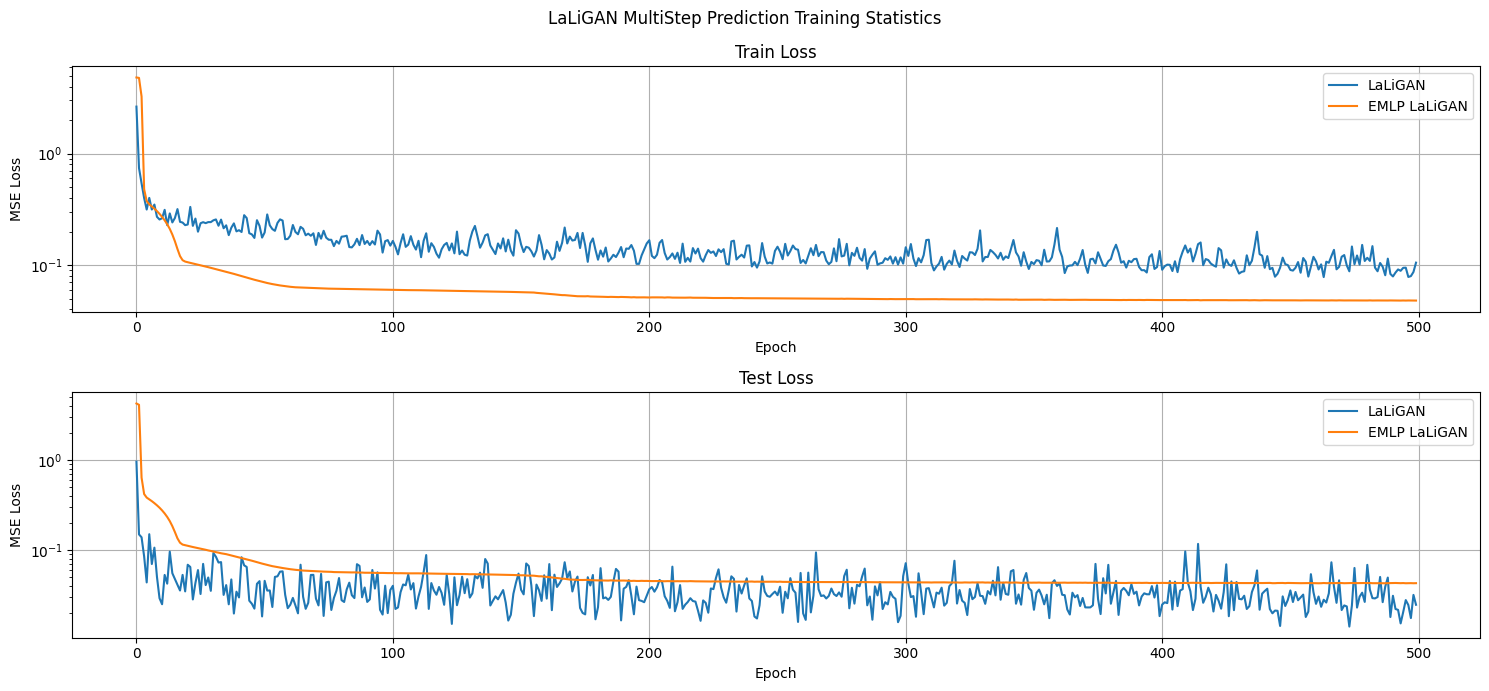

In [14]:
# Plot training statistics
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.plot(stats['train_loss'],label='LaLiGAN')
plt.plot(stats_emlp['train_loss'],label='EMLP LaLiGAN')
plt.yscale('log')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(stats['test_loss'],label='LaLiGAN')
plt.plot(stats_emlp['test_loss'],label='EMLP LaLiGAN')
plt.yscale('log')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.suptitle('LaLiGAN MultiStep Prediction Training Statistics')
plt.tight_layout()
plt.show()



In [15]:
print('Loading Pendulum dataset...') 
with open('data/pendulum_dataset.pkl','rb') as file:
    data_dict = pickle.load(file)

test_coords = data_dict['test_states']

Loading Pendulum dataset...


In [16]:
last_sequence = test_coords[0,:input_timesteps,:]
n_steps = len(test_coords[0,:,:])-len(last_sequence)

forecast = forecast_nn_laligan(regressor,autoencoder,last_sequence,n_steps,n_dim,latent_dim)
forecast_e = forecast_emlp_laligan(model_emlp,jax_autoencoder,last_sequence,n_steps,n_dim,latent_dim)

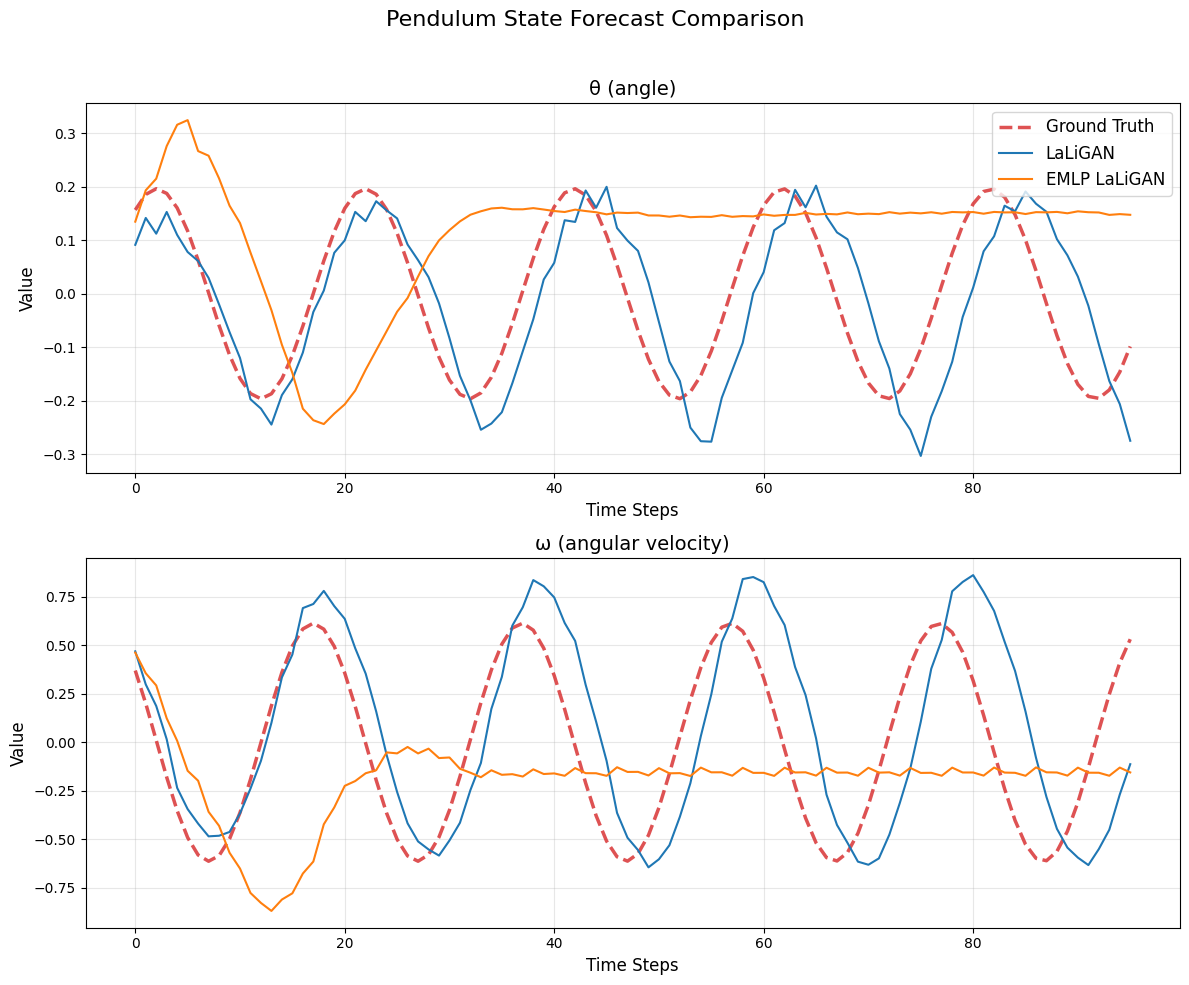

In [17]:
def plot_pendulum_forecasts(forecast, forecast_e, test_coords, input_timesteps):
    """
    Plot pendulum angle and angular velocity forecasts from different models.
    
    Parameters:
    -----------
    forecast : array - Baseline model predictions
    forecast_aug_v : array - Vanilla augmentation model predictions
    forecast_aug_i : array - Improved augmentation model predictions
    forecast_e : array - EMLP model predictions
    test_coords : array - Ground truth coordinates
    input_timesteps : int - Number of initial timesteps used for prediction
    """

    # Extract ground truth data for comparison
    n_steps = len(forecast)
    ground_truth = test_coords[0, input_timesteps:input_timesteps+n_steps]
    
    # Create time steps for x-axis
    time_steps = np.arange(n_steps)
    
    # Define a consistent color scheme
    colors = {
        'ground_truth': '#d62728',  # Red
        'baseline': '#1f77b4',      # Blue
        'aug_improved': '#2ca02c',  # Green
        'emlp': '#ff7f0e'           # Orange
    }
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle('Pendulum State Forecast Comparison', fontsize=16)
    
    # Variable names
    var_names = ['θ (angle)', 'ω (angular velocity)']
    
    # Plot both variables
    for i, ax in enumerate(axes.flat):
        # Plot predictions from all models
        ax.plot(time_steps, ground_truth[:, i], '--', color=colors['ground_truth'], 
                label='Ground Truth', linewidth=2.5, alpha=0.8)
        ax.plot(time_steps, forecast[:, i], '-', color=colors['baseline'], 
                label='LaLiGAN', linewidth=1.5)
        ax.plot(time_steps, forecast_e[:, i], '-', color=colors['emlp'], 
                label='EMLP LaLiGAN', linewidth=1.5)
        
        ax.set_title(f'{var_names[i]}', fontsize=14)
        ax.set_xlabel('Time Steps', fontsize=12)
        ax.set_ylabel('Value', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Only add legend to the first plot to save space
        if i == 0:
            ax.legend(fontsize=12, loc='best')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
    plt.show()

# Call the function with your pendulum data
plot_pendulum_forecasts(
    forecast, 
    forecast_e, 
    test_coords, 
    input_timesteps, 
)

In [18]:
## Computing Error metrics 

n = 10  # Number of samples
indices = np.random.choice(test_coords.shape[0], min(n,test_coords.shape[0]), replace=False)

def mse_comp(arr1,arr2):
    assert arr1.shape == arr2.shape 

    squared_diff = (arr1-arr2)**2 
    return np.mean(squared_diff)

mse = {
    'LaLiGAN':[],
    'EMLP LaLiGAN':[],
}

for i,idx in enumerate(indices):
    print(f'Trial {i+1}')
    sim = test_coords[idx,input_timesteps:,:]

    last_sequence = test_coords[idx,:input_timesteps,:]
    n_steps = len(test_coords[idx,:,:])-len(last_sequence)

    nn_forecast = forecast_nn_laligan(regressor,autoencoder,last_sequence,n_steps,n_dim,latent_dim)
    emlp_forecast = forecast_emlp_laligan(model_emlp,jax_autoencoder,last_sequence,n_steps,n_dim,latent_dim)


    mse['LaLiGAN'].append(mse_comp(sim,nn_forecast))
    mse['EMLP LaLiGAN'].append(mse_comp(sim,emlp_forecast))




Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


In [19]:
for k in mse.keys():
    print(f'{k} : {np.mean(mse[k])}')

LaLiGAN : 3.010509180719161
EMLP LaLiGAN : 3.08044365902324


In [20]:
print('LaLIEGAN :',stats['test_loss'][-1])
print('LaLIEGAN EMLP :',stats_emlp['test_loss'][-1])

LaLIEGAN : 0.024440271513802663
LaLIEGAN EMLP : 0.04253493675163814
